In [ ]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(sklearn.__version__)

from sklearn.datasets import load_wine
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.inspection import DecisionBoundaryDisplay

1.2.2


<p align="justify">Задача: В данном ноутбуке решается задача классификации с тремя возможными классами на наборе данных о винах. Данные на которых происходит обучение и тестирование классификатора представляют собой 178 объектов, каждый из которых представляет собой вектор размерности 13 содержащий данные об измерениях тех или иных показателей вина. Каждый признак имеет количественный тип данных. Целевая переменная имеет категориальный тип и может принимать три возможных значения: 'class_0', 'class_1' и 'class_2'. Для решения задачи используется метод k-ближайших соседей.

In [ ]:
data = load_wine()

X = data['data']
y = data['target']

y_df = pd.DataFrame(y)
y_df[0].replace(['class_0', 'class_1', 'class_2'], [0, 1, 2])

y = y_df.to_numpy().flatten()

print(X.shape)
print(y.shape)

(178, 13)
(178,)


Данные были разделены на обучающую и тестовую выборки в соотношении: 75:25

In [ ]:
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train_df = pd.DataFrame(X_train, columns=data.feature_names)
X_train_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.560526,0.299389,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.756329,0.434879,0.447154,0.695971,0.714736
1,0.276316,0.242363,0.181818,0.355670,0.293478,0.431034,0.386076,0.245283,0.310127,0.172185,0.642276,0.619048,0.340426
2,0.365789,0.720978,0.732620,0.819588,0.347826,0.420690,0.377637,0.566038,0.408228,0.037528,0.357724,0.677656,0.068558
3,0.407895,0.081466,0.395722,0.484536,0.358696,0.172414,0.050633,0.754717,0.310127,0.646799,0.081301,0.102564,0.285264
4,0.736842,0.154786,0.663102,0.340206,0.260870,0.506897,0.559072,0.169811,0.591772,0.426049,0.617886,0.769231,0.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,0.744737,0.126273,0.700535,0.742268,0.173913,0.679310,0.531646,0.150943,0.458861,0.181015,0.715447,0.692308,0.104019
129,0.321053,0.171079,0.406417,0.432990,0.108696,0.231034,0.356540,0.452830,0.382911,0.183223,0.422764,0.695971,0.182821
130,0.881579,0.199593,0.545455,0.072165,0.347826,0.800000,0.696203,0.301887,0.803797,0.635762,0.585366,0.633700,1.000000
131,0.436842,0.130346,0.481283,0.520619,0.108696,0.137931,0.236287,0.849057,0.379747,0.144592,0.390244,0.289377,0.171001


Для сравнения применяются два классификатора: c параметрами по умолчанию (n_beighbors=5, metric='minkowski', p=2), и с оптимальными, подобранными с помощью GridSearchCV. Для оценки моделей используется функция cross_val_score().

In [ ]:
# Евклидовская метрика
default_classifier = KNeighborsClassifier()
default_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
default_classifier_scores = cross_val_score(default_classifier, X_test, y_test, scoring='accuracy')
print('Среднее значение оценки:', default_classifier_scores.mean(), 'Среднеквадратичное отклонение оценки:', default_classifier_scores.std())

Среднее значение оценки: 0.9777777777777779 Среднеквадратичное отклонение оценки: 0.04444444444444447


Для поиска оптимальных гиперпараметров используется следующая сетка значений:
1.   число соседей от 1 до 10
2.   распределение весов:
  *   uniform (веса всех соседей равны между собой)
  *   distance (вес соседа убывает пропорционально расстоянию от объекта)
3. метрики:
    *   'cityblock' - манхэттенская метрика:
$$\rho(x, y) = \sum\limits_{i=1}^{n}|x_{i} - y_{i}|$$
    *   'cosine' - косинусная близость:
$$\rho(x, y) = \frac{xy^T}{||x|| \cdot ||y||}$$ где ||x|| - l2-норма (корень суммы квадратов координат)
    * 'euclidean' - евклидова метрика:
$$\rho(x, y) = \sqrt{\sum\limits_{i=1}^{n}(x_{i} - y_{i})^2}$$








In [ ]:
# поиск оптимальных параметров
classifier = KNeighborsClassifier()

n_neighbors_list = np.arange(1, 10)
weights_list = ['uniform', 'distance']
metric_list = ['cityblock', 'cosine', 'euclidean']

param_grid = {'n_neighbors': n_neighbors_list, 'weights': weights_list, 'metric': metric_list}

optimizer = GridSearchCV(classifier, param_grid, scoring='accuracy', error_score=0.0)

In [ ]:
optimizer.fit(X_train, y_train)
print('Оптимальные параметры:', optimizer.best_params_)

Оптимальные параметры: {'metric': 'cityblock', 'n_neighbors': 9, 'weights': 'uniform'}


In [ ]:
cv_results = pd.DataFrame(optimizer.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000883,0.000261,0.003607,0.001014,cityblock,1,uniform,"{'metric': 'cityblock', 'n_neighbors': 1, 'wei...",0.962963,1.000000,0.962963,0.961538,0.961538,0.969801,0.015113,9
1,0.000996,0.000759,0.001219,0.000281,cityblock,1,distance,"{'metric': 'cityblock', 'n_neighbors': 1, 'wei...",0.962963,1.000000,0.962963,0.961538,0.961538,0.969801,0.015113,9
2,0.000698,0.000157,0.003064,0.000131,cityblock,2,uniform,"{'metric': 'cityblock', 'n_neighbors': 2, 'wei...",0.925926,1.000000,0.925926,0.961538,0.923077,0.947293,0.029935,34
3,0.000615,0.000022,0.001048,0.000022,cityblock,2,distance,"{'metric': 'cityblock', 'n_neighbors': 2, 'wei...",0.962963,1.000000,0.962963,0.961538,0.961538,0.969801,0.015113,9
4,0.000638,0.000031,0.003009,0.000133,cityblock,3,uniform,"{'metric': 'cityblock', 'n_neighbors': 3, 'wei...",0.962963,1.000000,0.925926,0.961538,0.961538,0.962393,0.023435,15
5,0.000778,0.000222,0.001200,0.000092,cityblock,3,distance,"{'metric': 'cityblock', 'n_neighbors': 3, 'wei...",0.962963,1.000000,0.925926,0.961538,0.961538,0.962393,0.023435,15
6,0.000692,0.000041,0.003111,0.000192,cityblock,4,uniform,"{'metric': 'cityblock', 'n_neighbors': 4, 'wei...",0.962963,0.962963,0.925926,0.961538,0.923077,0.947293,0.018639,35
7,0.000603,0.000021,0.001064,0.000028,cityblock,4,distance,"{'metric': 'cityblock', 'n_neighbors': 4, 'wei...",0.962963,1.000000,0.925926,0.961538,0.961538,0.962393,0.023435,15
8,0.000599,0.000015,0.002949,0.000071,cityblock,5,uniform,"{'metric': 'cityblock', 'n_neighbors': 5, 'wei...",0.962963,1.000000,0.925926,0.961538,0.961538,0.962393,0.023435,15
9,0.000667,0.000095,0.001113,0.000044,cityblock,5,distance,"{'metric': 'cityblock', 'n_neighbors': 5, 'wei...",0.962963,1.000000,0.925926,0.961538,0.961538,0.962393,0.023435,15


In [ ]:
opt_classifier = optimizer.best_estimator_

In [ ]:
opt_classifier_scores = np.mean(cross_val_score(opt_classifier, X_test, y_test, scoring='accuracy'))
print('Среднее значение оценки:', opt_classifier_scores.mean(), 'Среднеквадратичное отклонение оценки:', opt_classifier_scores.std())

Среднее значение оценки: 0.9777777777777779 Среднеквадратичное отклонение оценки: 0.0


In [ ]:
results = pd.DataFrame(
    {'число_соседей': [default_classifier.n_neighbors, opt_classifier.n_neighbors],
     'метрика': [default_classifier.metric, opt_classifier.metric],
     'распределение_весов': [default_classifier.weights, opt_classifier.weights],
     'среднее_значение_оценки': [default_classifier_scores.mean(), opt_classifier_scores.mean()],
     'среднеквадратичное_отклонение_оценки': [default_classifier_scores.std(), opt_classifier_scores.std()]},
    index=['параметры по умолчанию', 'оптимальные параметры']
)

results

,число_соседей,метрика,распределение_весов,среднее_значение_оценки,среднеквадратичное_отклонение_оценки
параметры по умолчанию,5,minkowski,uniform,0.977778,0.044444
оптимальные параметры,9,cityblock,uniform,0.977778,0.000000


Как видно из полученных результатов, классификатор с параметрами по умолчанию имеет в среднем оценку такую же как и классификатор с оптимальными параметрами, также манхеттенская метрика и увеличенное число соседей показывает более стабильный результат.

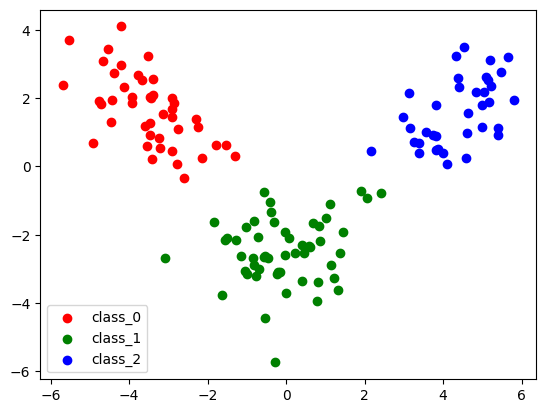

In [ ]:
# находим проекцию:
lda = LDA(n_components=2)

X_train_project = pd.DataFrame(lda.fit_transform(X_train, y_train))
X_test_project = pd.DataFrame(lda.transform(X_test))

plt.scatter(X_train_project[y_train==0][0], X_train_project[y_train==0][1], label='class_0', c='red')
plt.scatter(X_train_project[y_train==1][0], X_train_project[y_train==1][1], label='class_1', c='green')
plt.scatter(X_train_project[y_train==2][0], X_train_project[y_train==2][1], label='class_2', c='blue')

plt.legend()
plt.show()

In [ ]:
opt_classifier_proj = KNeighborsClassifier(n_neighbors=opt_classifier.n_neighbors, metric=opt_classifier.metric, weights=opt_classifier.weights)

opt_classifier_proj.fit(X_train_project, y_train)
proj_scores = cross_val_score(default_classifier, X_test_project, y_test)
proj_scores.mean()

1.0

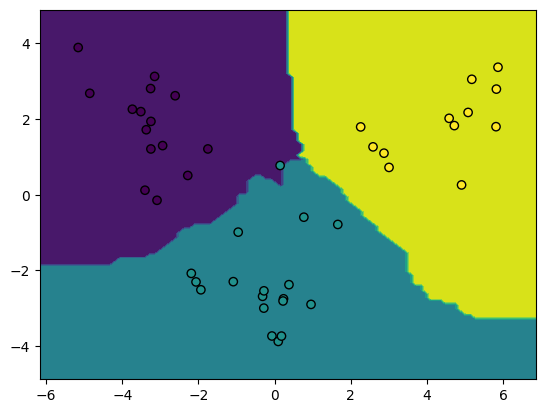

In [ ]:
X_pr_arr = X_test_project.to_numpy()
disp = DecisionBoundaryDisplay.from_estimator(opt_classifier_proj, X_pr_arr, response_method="predict")

disp.ax_.scatter(X_pr_arr[:, 0], X_pr_arr[:, 1], c=y_test, edgecolor='k')

#Парзеновское окно
<p allign='justify'>Модификация метода ближайших соседей, аппроксимирующая плотность распределения данных по выборке с помощью функции ядра. В данном методе оценка плотности распределения принадлежности объекта x классу y имеет вид:
$$p_{y, h}(x) = \sum\limits_{i=1}^{n}[y_{i}=y]K(\frac{\rho(x, x_{i})}{h})$$
где n - размер обучающей выборки, h - ширина парзеновского окна (чем шире окно, тем более далекие от x объекты будут иметь вес сильно больше нуля), K(z) - функция ядра




In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

# реализация класса, применяющего метод парзеновского окна, с методами predict и predict_proba
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE

    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, metric='euclidean', kernel='gaussian'):
        self.bandwidth = bandwidth
        self.metric = metric
        self.kernel = kernel

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel, metric=self.metric).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self

    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [ ]:
parsen_clf = KDEClassifier()

bandwidth_list = np.logspace(0.0, 5.0, num=30)
kernel_list = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric_list = ['cityblock', 'euclidean']

param_grid_parsen = {'bandwidth': bandwidth_list, 'kernel': kernel_list, 'metric': metric_list}

optimizer_parsen = GridSearchCV(parsen_clf, param_grid_parsen, error_score=0.0)

In [ ]:
optimizer_parsen.fit(X_train, y_train)
print('Оптимальные параметры:', optimizer_parsen.best_params_)

<ipython-input-41-febd10a97377>:32: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
<ipython-input-41-febd10a97377>:32: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
<ipython-input-41-febd10a97377>:32: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
<ipython-input-41-febd10a97377>:32: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
<ipython-input-41-febd10a97377>:32: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
<ipython-input-41-febd10a97377>:32: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
<ipython-input-41-febd10a97377>:32: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
<ipython-input-41-febd10a97377>:32: RuntimeWarning: inv

Оптимальные параметры: {'bandwidth': 1.4873521072935114, 'kernel': 'exponential', 'metric': 'cityblock'}


In [ ]:
parsen_cv_results = pd.DataFrame(optimizer_parsen.cv_results_)
parsen_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bandwidth,param_kernel,param_metric,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001280,0.000504,0.001236,0.000167,1.0,gaussian,cityblock,"{'bandwidth': 1.0, 'kernel': 'gaussian', 'metr...",0.962963,1.000000,0.925926,0.961538,0.961538,0.962393,0.023435,4
1,0.001013,0.000033,0.001336,0.000337,1.0,gaussian,euclidean,"{'bandwidth': 1.0, 'kernel': 'gaussian', 'metr...",0.888889,0.814815,0.851852,0.807692,0.923077,0.857265,0.043864,27
2,0.001196,0.000113,0.001744,0.000377,1.0,tophat,cityblock,"{'bandwidth': 1.0, 'kernel': 'tophat', 'metric...",0.518519,0.518519,0.666667,0.576923,0.500000,0.556125,0.061042,43
3,0.001227,0.000211,0.001332,0.000356,1.0,tophat,euclidean,"{'bandwidth': 1.0, 'kernel': 'tophat', 'metric...",0.962963,0.962963,0.925926,0.961538,0.846154,0.931909,0.045158,21
4,0.001645,0.000450,0.001634,0.000069,1.0,epanechnikov,cityblock,"{'bandwidth': 1.0, 'kernel': 'epanechnikov', '...",0.518519,0.518519,0.666667,0.576923,0.500000,0.556125,0.061042,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.001021,0.000027,0.001133,0.000016,100000.0,exponential,euclidean,"{'bandwidth': 100000.0, 'kernel': 'exponential...",0.407407,0.407407,0.370370,0.384615,0.423077,0.398575,0.018691,61
356,0.001042,0.000080,0.001160,0.000014,100000.0,linear,cityblock,"{'bandwidth': 100000.0, 'kernel': 'linear', 'm...",0.407407,0.407407,0.370370,0.384615,0.423077,0.398575,0.018691,61
357,0.001044,0.000043,0.001296,0.000165,100000.0,linear,euclidean,"{'bandwidth': 100000.0, 'kernel': 'linear', 'm...",0.407407,0.407407,0.370370,0.384615,0.423077,0.398575,0.018691,61
358,0.001036,0.000081,0.001285,0.000129,100000.0,cosine,cityblock,"{'bandwidth': 100000.0, 'kernel': 'cosine', 'm...",0.407407,0.407407,0.370370,0.384615,0.423077,0.398575,0.018691,61


In [ ]:
parsen_opt_clf = optimizer_parsen.best_estimator_

parsen_opt_clf_scores = cross_val_score(parsen_opt_clf, X_test, y_test)
print('Среднее значение оценки:', parsen_opt_clf_scores.mean())
print('Cреднеквадратичное отклонение оценки:', parsen_opt_clf_scores.std())

Среднее значение оценки: 0.9555555555555555
Cреднеквадратичное отклонение оценки: 0.08888888888888889


In [ ]:
parsen_clf_proj = KDEClassifier(metric='cityblock', kernel='exponential')

parsen_clf_proj.fit(X_train_project, y_train)
parsen_clf_proj_score = cross_val_score(parsen_clf_proj, X_test_project, y_test)
parsen_clf_proj_score.mean()

1.0

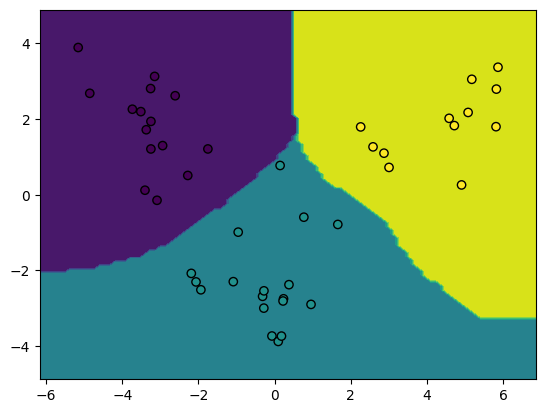

In [ ]:
disp = DecisionBoundaryDisplay.from_estimator(parsen_clf_proj, X_pr_arr, response_method="predict")

disp.ax_.scatter(X_pr_arr[:, 0], X_pr_arr[:, 1], c=y_test, edgecolor='k')

Можно заметить, что разделяющая поверхность при использовании парзеновского окна более гладкая, чем при использовании метода ближайших соседей.

In [ ]:
results = pd.DataFrame(
    {'число_соседей': [default_classifier.n_neighbors, opt_classifier.n_neighbors, parsen_opt_clf.bandwidth],
     'метрика': [default_classifier.metric, opt_classifier.metric, parsen_opt_clf.metric],
     'распределение_весов': [default_classifier.weights, opt_classifier.weights, parsen_opt_clf.kernel],
     'среднее_значение_оценки': [default_classifier_scores.mean(), opt_classifier_scores.mean(), parsen_opt_clf_scores.mean()],
     'среднеквадратичное_отклонение_оценки': [default_classifier_scores.std(), opt_classifier_scores.std(), parsen_opt_clf_scores.std()]},
    index=['параметры по умолчанию', 'оптимальные параметры', 'парзеновское окно']
)

results

,число_соседей,метрика,распределение_весов,среднее_значение_оценки,среднеквадратичное_отклонение_оценки
параметры по умолчанию,5.000000,minkowski,uniform,0.977778,0.044444
оптимальные параметры,9.000000,cityblock,uniform,0.977778,0.000000
парзеновское окно,1.487352,cityblock,exponential,0.955556,0.088889
